In [53]:
!pip install -q transformers torch torchvision albumentations 

# init

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from PIL import Image
import numpy as np
import torchvision.transforms.functional as TF

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Unet model

In [2]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224 

class DoubleConv(nn.Module):
    ######################################
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    ######################################
    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    ######################################
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        self.transform = A.Compose(
            [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )        

    ######################################
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
    ######################################
    def predict(self,input_image):
        augmentations = self.transform(image=np.array(input_image))
        image1 = augmentations['image']
        images = torch.unsqueeze(image1, 0)

        outputs = self(images)
        preds = torch.sigmoid(outputs)
        predicted_mask = (preds > 0.5).float()
        mask = self.prediction_to_vis(predicted_mask[0,:,:])
        mask = mask.resize(input_image.size)
        return mask


    
    ######################################
    def load_checkpoint(self,checkpoint):
        print("=> Loading checkpoint")
        self.load_state_dict(checkpoint["state_dict"])    
        
    ######################################
    def create_crops(self, img, crop_size=(224, 224)):
        img_width, img_height = img.size

        crops = []
        for start_x in range(0, img_width, crop_size[0]):
            if start_x + crop_size[0] > img_width:
                start_x = img_width - crop_size[0]
            for start_y in range(0, img_height, crop_size[1]):
                if start_y + crop_size[1] > img_height:
                    start_y = img_height- crop_size[1]
                    # break

                imgCrop = img.crop((start_x, start_y, start_x + crop_size[0], start_y + crop_size[1]))

                crops.append(imgCrop)
        return crops        
    

    
    ######################################
    def reconstruct_image(self,crops, original_size):
        """
        Reconstructs the original image from a list of non-overlapping crops.

        Args:
            crops (list): A list of PIL Image objects representing the crops.
            original_size (tuple): A tuple (width, height) representing the size
                of the original image.

        Returns:
            PIL.Image: The reconstructed original image.

        Raises:
            ValueError: If the number of crops doesn't match the expected number
                based on the original size and crop size used in `create_crops`.
        """

        crop_width, crop_height = crops[0].size  # Assuming all crops have the same size

        # Calculate the expected number of crops based on original size and crop size
        expected_num_crops_x = int(original_size[0] / crop_width) + (
            1 if original_size[0] % crop_width != 0 else 0
        )
        expected_num_crops_y = int(original_size[1] / crop_height) + (
            1 if original_size[1] % crop_height != 0 else 0
        )
        expected_total_crops = expected_num_crops_x * expected_num_crops_y

        if len(crops) != expected_total_crops:
            raise ValueError(
                "Number of crops ({}) doesn't match expected number ({}) based on original size and crop size used in create_crops.".format(
                    len(crops), expected_total_crops
                )
            )

        # Create a new image with the original size and the same mode as the crops
        reconstructed_img = Image.new(crops[0].mode, original_size)
        paste_x, paste_y = 0, 0

        for i, crop in enumerate(crops):
            reconstructed_img.paste(crop, (paste_x, paste_y))

            # Update paste coordinates for the next crop
            paste_y += crop_height

            if paste_y == original_size[1]:
                # cv2.imshow("reconstructed_img",np.array(reconstructed_img))
                # cv2.waitKey()
                paste_y = 0
                paste_x += crop_width
                if paste_x > original_size[0] - crop_width:
                    paste_x = original_size[0] - crop_width

            if paste_y > original_size[1]-crop_height:
                paste_y = original_size[1]-crop_height
                
        return reconstructed_img


    ######################################
    def prediction_to_vis(self,prediction):
        vis_shape = prediction.shape + (3,)
        vis = np.zeros(vis_shape)
        for i,c in color_map.items():
            vis[prediction == i] = color_map[i]
        return Image.fromarray(vis.astype(np.uint8).squeeze())
    
    ######################################
    def predictImg(self,input_image):
        crops = self.create_crops(input_image)
        input_crops = []
        for input_crop in crops:
            augmentations = self.transform(image=np.array(input_crop))
            input_crops.append(augmentations['image'].unsqueeze(0))
        input_crops = torch.cat(input_crops, dim=0)
        outputs = self(input_crops)
        preds = torch.sigmoid(outputs)
        predicted_mask = (preds > 0.5).float()        
        crop_mask = []
        for i in range(len(predicted_mask)):
            mask = predicted_mask[i,:,:].numpy().squeeze()
            mask[mask > 0] = 255
            mask = Image.fromarray(mask)
            crop_mask.append(mask)
      
        finalMask = self.reconstruct_image(crop_mask,input_image.size)        
        return(finalMask)
            


# Train

In [3]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [4]:
ckpt = torch.load("/Users/eliaweiss/work/unet-blines/blines_dice0.93.pth.tar", map_location=torch.device(DEVICE))
model.load_checkpoint(ckpt)

=> Loading checkpoint


 # view results

In [18]:
# input_image_file = "../pdfBLines/dataset1/valid/1678281108-da80674ac533ff392cc03d66aac5cff0.jpg"
input_image_file = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
input_image = Image.open(input_image_file)

In [19]:
finalMask = model.predictImg(input_image)

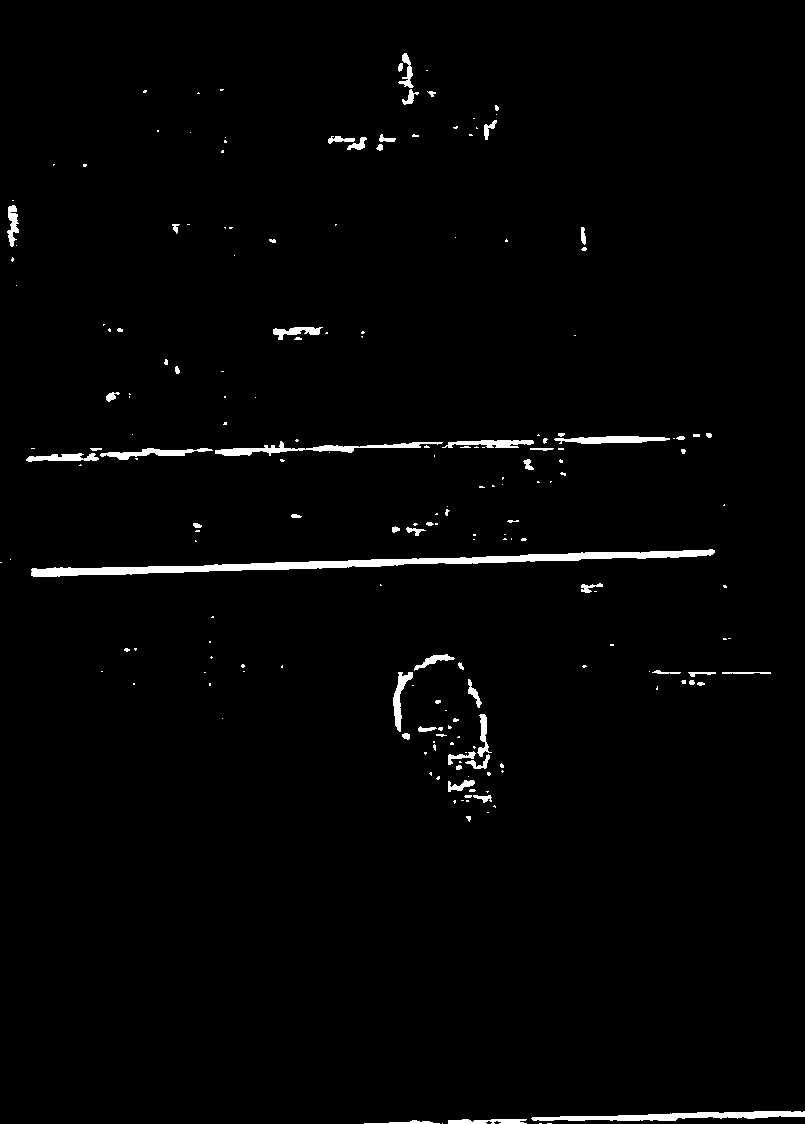

In [20]:
rgb_image = finalMask.convert("RGB")
rgb_image